In [1]:
from main import *
from useful_functions import *
from visualization import *
from stats import *

from brainspace.gradient.embedding import DiffusionMaps, diffusion_mapping
from scipy.stats import spearmanr

%matplotlib inline
plt.rcParams['font.size'] = 18

/home/anleg84/anaconda3/envs/calimba/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


# Setting paths

In [2]:
top_directory = '/media/anleg84/Backup Plus/CERVO/Data/Networks2024/'
atlas_path = '/home/anleg84/Documents/Atlas/Mapzebrain/'

atlas = MapzebrainAtlas(atlas_path)
excluded = np.load('Results/excluded_regions.npy')

centroids = np.concatenate([atlas.regionCentroids['left'], atlas.regionCentroids['right']], axis=0)
centroids[:, 1] = 974 - centroids[:, 1]
excluded = np.load('Results/excluded_regions.npy')
centroids = np.delete(centroids, np.concatenate([excluded, excluded + 70]), axis=0)
delete = delete_rows_and_columns

In [3]:
FC = np.load('Results/FC_matrix.npy')
SC = np.load('Results/undirected_terminals_expanded.npy')

In [4]:
from scipy.optimize import linear_sum_assignment

def compute_mode_similarity_matrix(modes1, modes2, return_mapping=False, method='pearson'):
    N_modes = modes1.shape[0]
    corrs = np.zeros((N_modes, N_modes))
    for i in range(N_modes):
        for j in range(N_modes):
            if method == 'pearson':
                corrs[i, j] = pearsonr(modes1[i], modes2[j])[0]
            elif method == 'spearman':
                corrs[i, j] = spearmanr(modes1[i], modes2[j])[0]
    
    cost_matrix = 1 - np.abs(corrs)
    _, mapping = linear_sum_assignment(cost_matrix)
    
    corrs = np.zeros((N_modes, N_modes))
    for i in range(N_modes):
        for j in range(N_modes):
            if method == 'pearson':
                corrs[i, j] = pearsonr(modes1[i], modes2[mapping[j]])[0]
            elif method == 'spearman':
                corrs[i, j] = spearmanr(modes1[i], modes2[mapping[j]])[0]
    if return_mapping:
        return corrs, mapping
    else:
        return corrs


# Loading region series

In [26]:
datasets = get_datasets(top_directory, ['920nm', 'wholebrain'])

In [48]:
sigma = 2
rseries = []
for ds in datasets:
    rseries.append(np.load(ds + 'region_series_dff.npy')[:, :])
    for i in range(rseries[-1].shape[0]):
        rseries[-1][i] = gaussian_filter1d(rseries[-1][i], sigma)

matrices = []
for ts in rseries:
    matrix = compute_correlation_matrix(ts)
    #matrix[np.isnan(matrix)] = 0
    matrices.append(matrix)
matrices = np.stack(matrices, axis=0)

matrices = np.delete(matrices, excluded, axis=1)
matrices = np.delete(matrices, excluded, axis=2)

FC_stim = np.nanmean(matrices, axis=0)

In [54]:
np.save('Results/figure6_FC_stim.npy', FC_stim)

# Functional network gradients

In [5]:
modes_FC, eigvals_FC = diffusion_mapping(FC, n_components=60)
#order = np.flip(np.argsort(np.abs(eigvals_FC)))
modes_FC = modes_FC.T
gradient1f = modes_FC[0]
gradient2f = modes_FC[1]

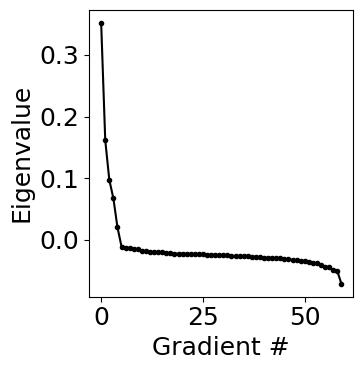

In [6]:
plt.figure(figsize=(4, 4))
plt.plot(eigvals_FC, marker='.', color='black')
plt.xlabel('Gradient #')
plt.ylabel('Eigenvalue')
plt.tight_layout(pad=1)

Text(0.5, 0, 'Mode #')

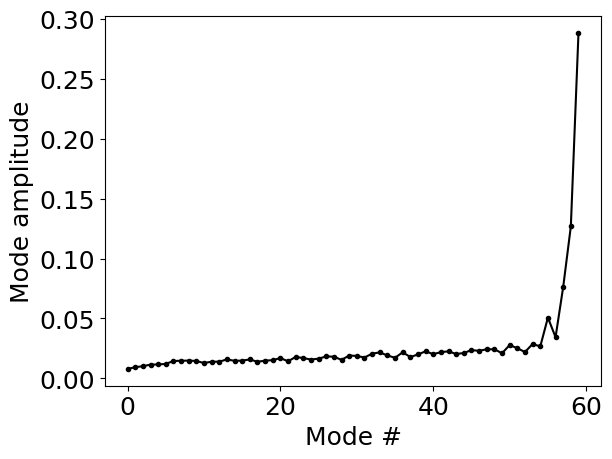

In [7]:
values = []
for m in modes_FC:
    #v = np.percentile(np.abs(m), 90)
    v = np.mean(np.abs(m))
    values.append(v)

plt.plot(np.array(values)[np.argsort(np.abs(eigvals_FC))], marker='.', color='black')
plt.ylabel('Mode amplitude')
plt.xlabel('Mode #')

First gradient

0.5384056017806481


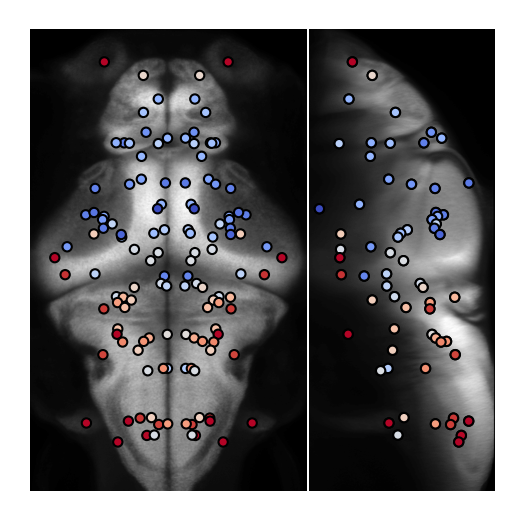

In [8]:
v = np.percentile(np.abs(modes_FC[0]), 90)
print(v)
plot_regional_values(modes_FC[0], atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

Second gradient

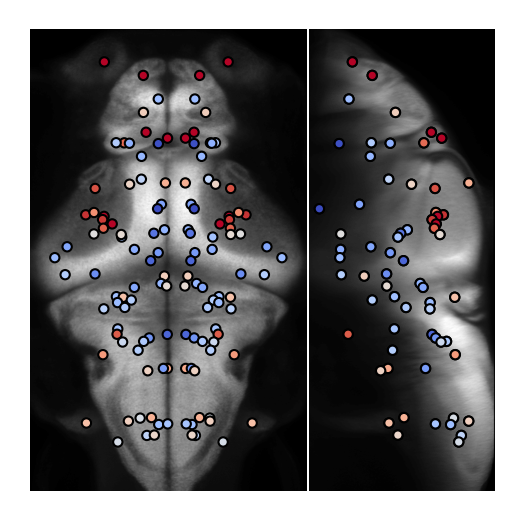

In [9]:
v = np.percentile(np.abs(modes_FC[1]), 90)
plot_regional_values(modes_FC[1], atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

Third gradient

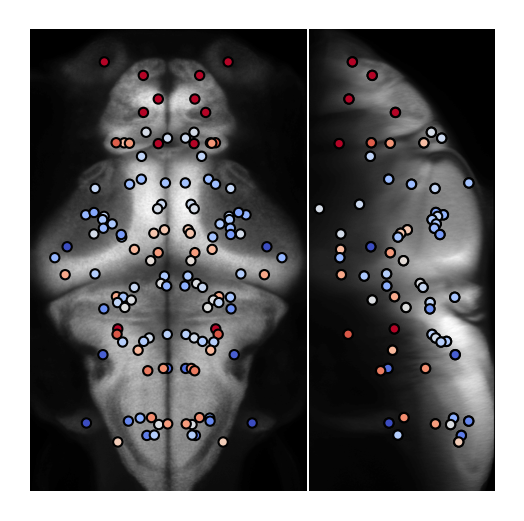

In [10]:
v = np.percentile(np.abs(modes_FC[2]), 90)
plot_regional_values(modes_FC[2], atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

In [27]:
np.save('Results/figure6_gradients_functional.npy', modes_FC)
np.save('Results/figure6_eigenvalues_functional.npy', eigvals_FC)

# Structural network gradients

In [11]:
%matplotlib inline

In [12]:
modes_SC, eigvals_SC = diffusion_mapping(SC, n_components=60, alpha=0.5)
modes_SC = np.delete(modes_SC, excluded, axis=0).T
gradient1s = modes_SC[0]
gradient2s = modes_SC[1]

Text(0, 0.5, 'Eigenvalue')

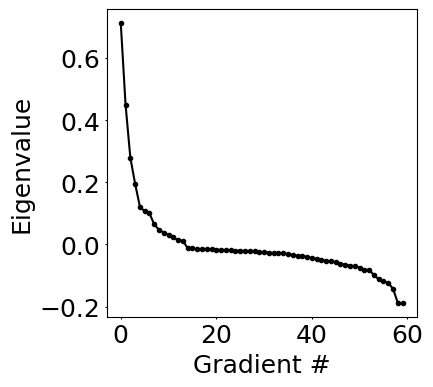

In [13]:
plt.figure(figsize=(4, 4))
plt.plot(eigvals_SC, marker='.', color='black')
plt.xlabel('Gradient #')
plt.ylabel('Eigenvalue')

Text(0.5, 0, 'Mode #')

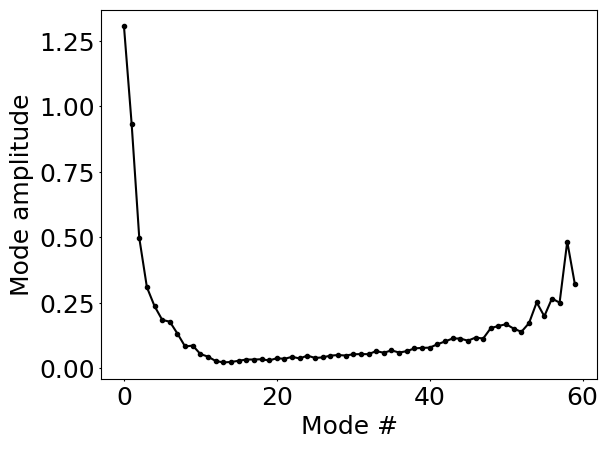

In [14]:
values = []
for m in modes_SC:
    v = np.percentile(np.abs(m), 95)
    values.append(v)

plt.plot(values, marker='.', color='black')
plt.ylabel('Mode amplitude')
plt.xlabel('Mode #')

First gradient

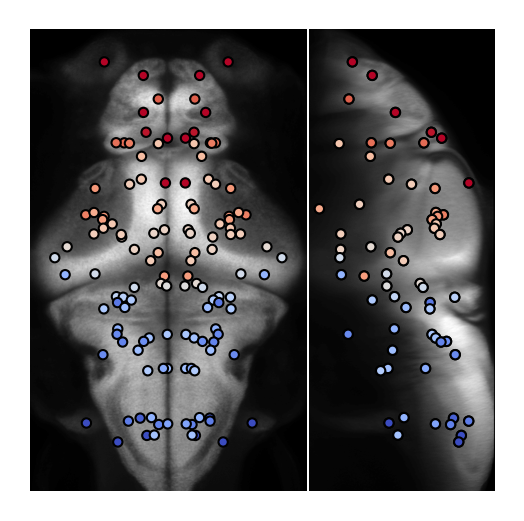

In [15]:
v = np.percentile(np.abs(modes_SC[0]), 90)
plot_regional_values(modes_SC[0], atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

Second gradient

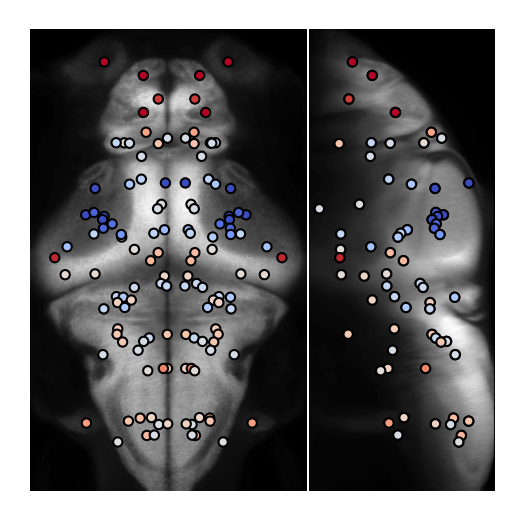

In [16]:
v = np.percentile(np.abs(modes_SC[1]), 90)
plot_regional_values(modes_SC[1], atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

Third gradient

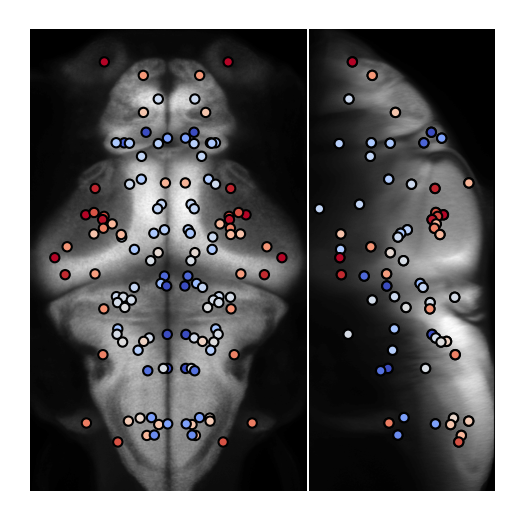

In [17]:
v = np.percentile(np.abs(modes_SC[2]), 90)
plot_regional_values(modes_SC[2], atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

In [35]:
np.save('Results/figure6_gradients_structural.npy', modes_SC)
np.save('Results/figure6_eigenvalues_structural.npy', eigvals_SC)

# Similarity between functional/structural modes

In [18]:
correlations, mapping = compute_mode_similarity_matrix(modes_SC, modes_FC, return_mapping=True, method='pearson')
correlations2, mapping2 = compute_mode_similarity_matrix(modes_SC, modes_FC, return_mapping=True, method='spearman')

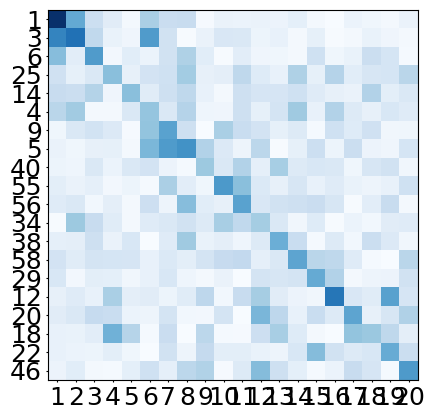

In [19]:
plt.imshow(np.abs(correlations)[:20, :20], cmap='Blues')
plt.xticks(np.arange(20), np.arange(20) + 1)
plt.yticks(np.arange(20), mapping[:20] + 1)
plt.show()

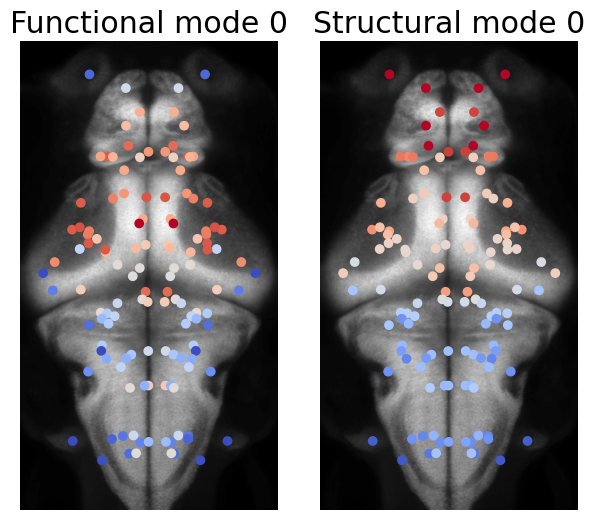

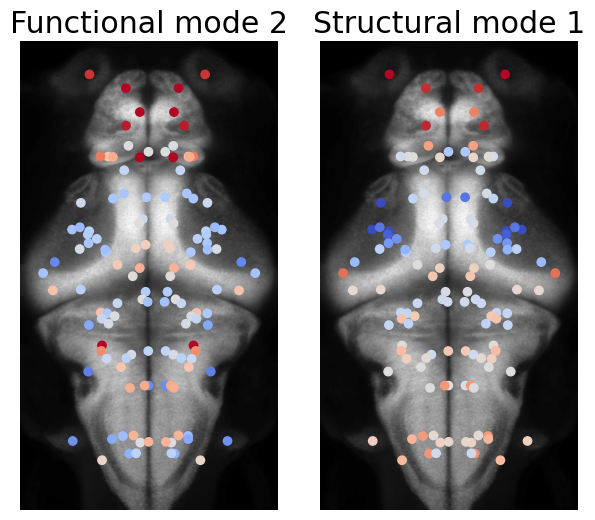

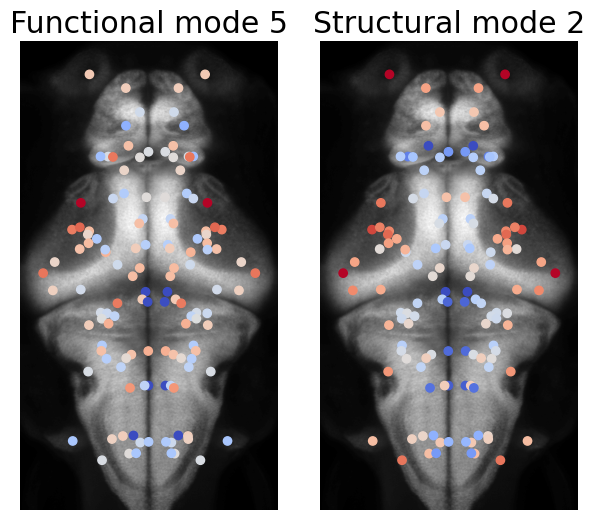

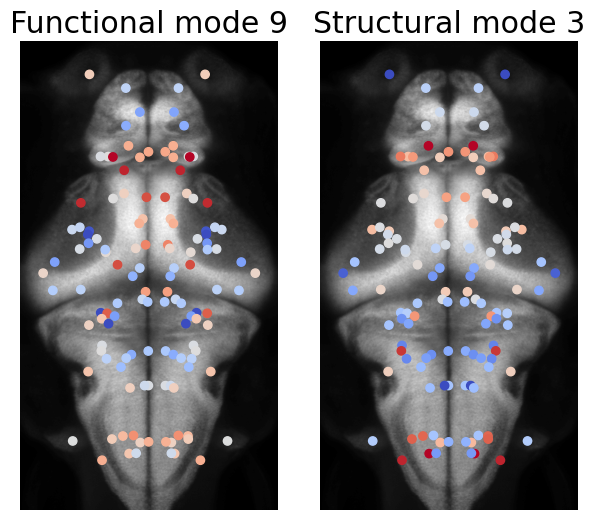

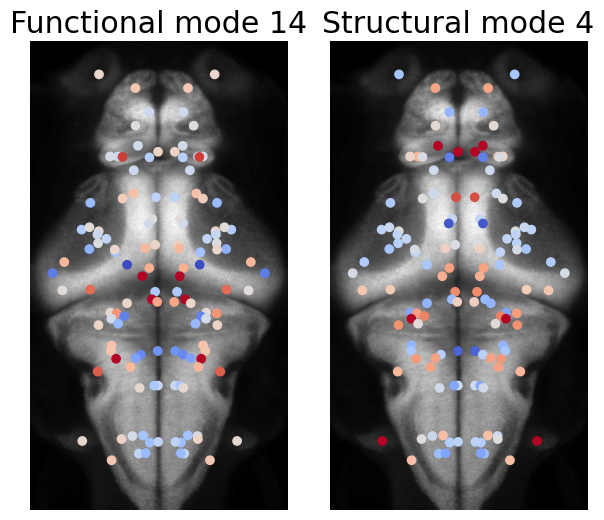

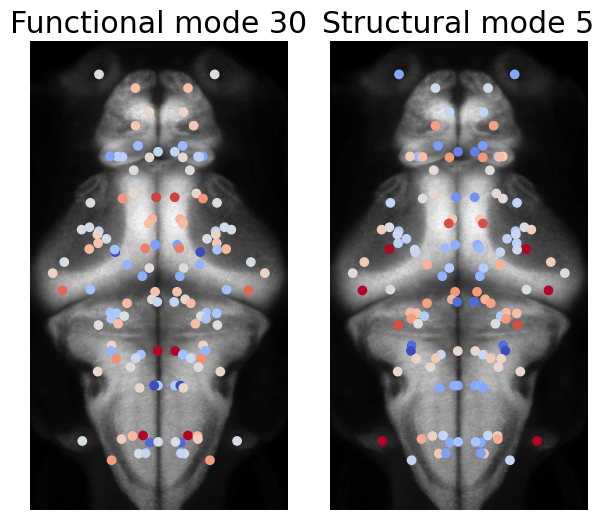

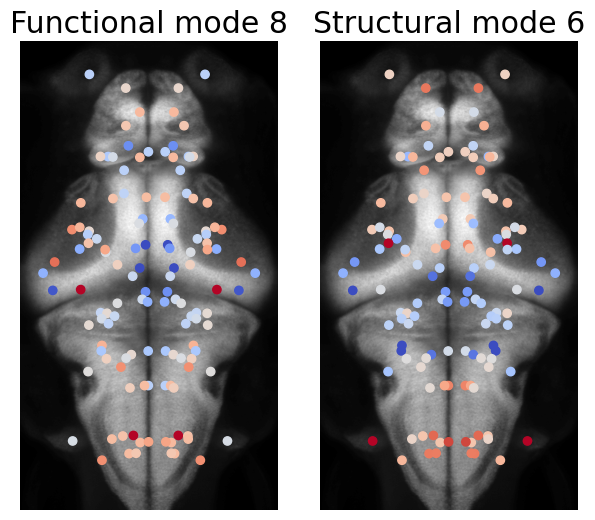

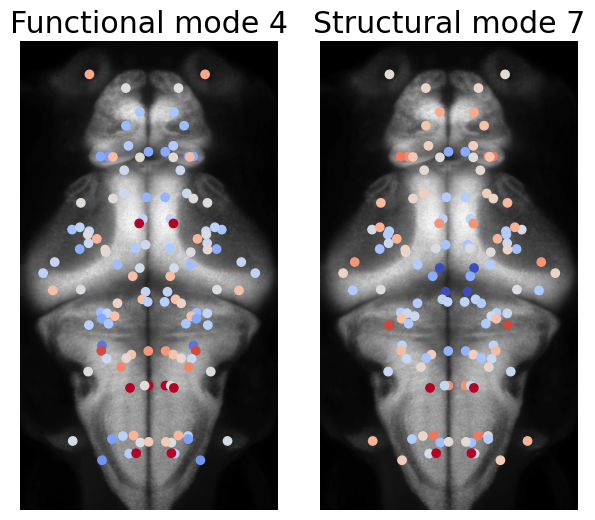

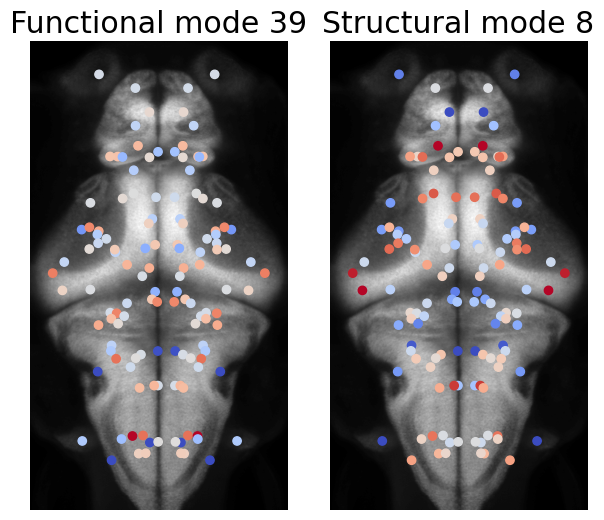

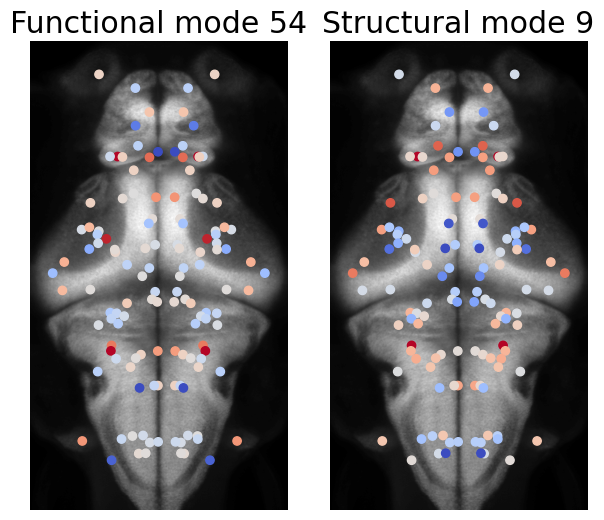

In [38]:
for i in range(10):

    fig, ax = plt.subplots(1, 2, figsize=(6, 5))
    sign = np.sign(correlations[i, i])
    
    v = np.percentile(np.abs(modes_FC[mapping[i]]), 95)
    ax[0].imshow(atlas.XYprojection, cmap='gray')
    ax[0].scatter(centroids[:, 0], centroids[:, 1], c=sign * double(modes_FC[mapping[i]]), cmap='coolwarm', vmin=-v, vmax=v)
    ax[0].set_xlim([65, 505])
    ax[0].set_ylim([850, 50])
    ax[0].axis('off')
    ax[0].set_title('Functional mode {}'.format(mapping[i]))
    
    v = np.percentile(np.abs(modes_SC[i]), 95)
    ax[1].imshow(atlas.XYprojection, cmap='gray')
    ax[1].scatter(centroids[:, 0], centroids[:, 1], c=double(modes_SC[i]), cmap='coolwarm', vmin=-v, vmax=v)
    ax[1].set_xlim([65, 505])
    ax[1].set_ylim([850, 50])
    ax[1].axis('off')
    ax[1].set_title('Structural mode {}'.format(i))
    
    plt.tight_layout(pad=0)

In [39]:
np.save('Results/figure6_correlations_modes.npy', correlations)
np.save('Results/figure6_mapping_modes.npy', mapping)

# Significance of SC-FC gradients correlation

#### 1. Comparing functional gradients with SCCM gradients

In [130]:
SC_SCCM = np.load('Results/null_SC_expanded_deltaD_30.npy')

corrs_null_all = []
for S in tqdm(SC_SCCM, file=sys.stdout):
    modes_SCCM, _ = diffusion_mapping(S, n_components=60, alpha=0.5)
    modes_SCCM = np.delete(modes_SCCM, excluded, axis=0).T
    corrs_null = compute_mode_similarity_matrix(modes_SCCM, modes_FC, method='pearson')
    corrs_null_all.append(np.diag(corrs_null))
corrs_null_all = np.array(corrs_null_all)

100%|███████████████████████████████████████| 1000/1000 [03:51<00:00,  4.33it/s]


Average across all modes

In [160]:
corrs_empirical = np.mean(np.abs(np.diag(correlations)))
null_distribution = np.mean(np.abs(corrs_null_all), axis=1)

In [161]:
percentileofscore(null_distribution, corrs_empirical)

99.9

First mode only

In [179]:
corr_empirical = np.abs(np.diag(correlations))[0]
null_distribution = np.abs(corrs_null_all)[:, 0]

In [180]:
percentileofscore(null_distribution, corr_empirical)

96.8

#### 2. Spatially shuffling gradients

In [182]:
distances = delete(atlas.computeDistanceBetweenRegions(), excluded)

In [181]:
from brainsmash.mapgen.base import Base

Correlations across all modes

In [190]:
corrs_null_all = []

for _ in tqdm(range(1000), file=sys.stdout):
    surrogate_modes = []
    for m in modes_FC[:10]:
        base = Base(x=m, D=distances, resample=True)
        surrogate = base(n=1)
        surrogate_modes.append(surrogate)
    surrogate_modes = np.stack(surrogate_modes, axis=0)
    corrs_null = compute_mode_similarity_matrix(modes_SC[:10], surrogate_modes, method='pearson')
    corrs_null_all.append(np.diag(corrs_null))
    
corrs_null_all = np.array(corrs_null_all)

100%|███████████████████████████████████████| 1000/1000 [05:18<00:00,  3.14it/s]


In [195]:
corrs_empirical = np.mean(np.abs(np.diag(correlations))[:10])
null_distribution = np.mean(np.abs(corrs_null_all), axis=1)

In [196]:
percentileofscore(null_distribution, corrs_empirical)

99.8

First mode only

In [252]:
corrs_null_first = []

for _ in tqdm(range(1000), file=sys.stdout):
    base = Base(x=modes_FC[0], D=distances, resample=True)
    surrogate = base(n=1)
    r = pearsonr(surrogate, modes_SC[0])[0]
    corrs_null_first.append(r)

100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 30.80it/s]


In [253]:
corr_empirical = np.abs(correlations[0, 0])
null_distribution = np.abs(corrs_null_first)

In [254]:
percentileofscore(null_distribution, corr_empirical)

80.2

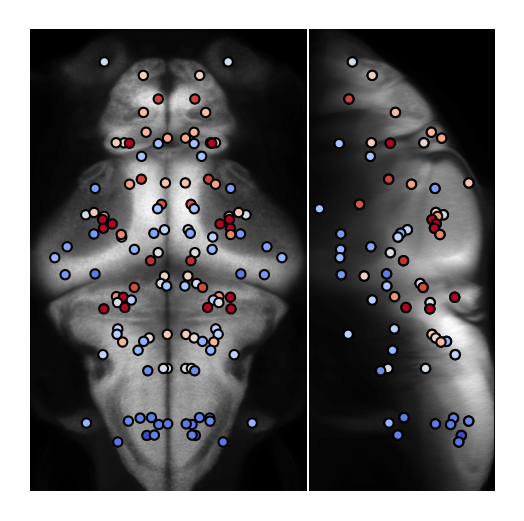

In [255]:
v = np.percentile(np.abs(surrogate), 90)
plot_regional_values(surrogate, atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

# Computing sensorimotor index per brain region

In [40]:
N_neurons_per_region = np.load('Results/N_neurons_per_region.npy')

In [226]:
corrs_per_region_dark, cells_per_region_dark = [], []
corrs_per_region_motor, cells_per_region_motor = [], []

for folder in tqdm(datasets, file=sys.stdout):

    if 'correlated_motor.npy' in identify_files(folder, ['.npy']):

        coprd, ceprd = [], []
        coprm, ceprm = [], []
        
        data = load_data(folder)
        corrs_dark = np.load(folder + 'correlations_dark.npy')
        corrs_motor = np.load(folder + 'correlations_motor.npy')
        cells_dark = np.load(folder + 'correlated_dark.npy')
        cells_motor = np.load(folder + 'correlated_motor.npy')
        regions = data['region_labels']
    
        for i in range(regions.shape[1]):
            in_region = regions[:, i] > 0
            coprd.append(np.mean(corrs_dark[in_region]))
            ceprd.append(np.sum(cells_dark[in_region]))
            coprm.append(np.mean(corrs_motor[in_region]))
            ceprm.append(np.sum(cells_motor[in_region]))

    corrs_per_region_dark.append(coprd)
    cells_per_region_dark.append(ceprd)
    corrs_per_region_motor.append(coprm)
    cells_per_region_motor.append(ceprm)

corrs_per_region_dark = np.stack(corrs_per_region_dark)
cells_per_region_dark = np.stack(cells_per_region_dark)
corrs_per_region_motor = np.stack(corrs_per_region_motor)
cells_per_region_motor = np.stack(cells_per_region_motor)

corrs_per_region_dark[np.isnan(corrs_per_region_dark)] = 0
corrs_per_region_motor[np.isnan(corrs_per_region_motor)] = 0

  5%|██                                          | 1/22 [00:05<01:46,  5.06s/it]

/home/anleg84/anaconda3/envs/calimba/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/anleg84/anaconda3/envs/calimba/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


100%|███████████████████████████████████████████| 22/22 [01:39<00:00,  4.53s/it]


In [227]:
fraction_dark = np.mean(cells_per_region_dark, axis=0) / (np.mean(N_neurons_per_region, axis=0) + 1)
fraction_motor = np.mean(cells_per_region_motor, axis=0) / (np.mean(N_neurons_per_region, axis=0) + 1)
corrs_dark = np.mean(corrs_per_region_dark, axis=0)
corrs_motor = np.mean(corrs_per_region_motor, axis=0)

In [228]:
score_visual = fraction_dark
score_visual = np.delete(score_visual, excluded)
score_motor = fraction_motor
score_motor = np.delete(score_motor, excluded)

In [229]:
sensorimotor_index = score_visual - score_motor

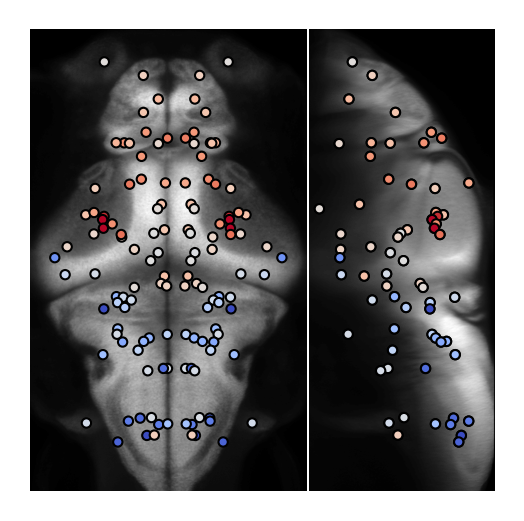

In [230]:
v = np.percentile(np.abs(sensorimotor_index), 95)
plot_regional_values(sensorimotor_index, atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

In [231]:
np.save('Results/figure6_sensorimotor_index.npy', sensorimotor_index)

# Comparing gradients with sensorimotor index

In [41]:
sensorimotor_index = np.load('Results/figure6_sensorimotor_index.npy')

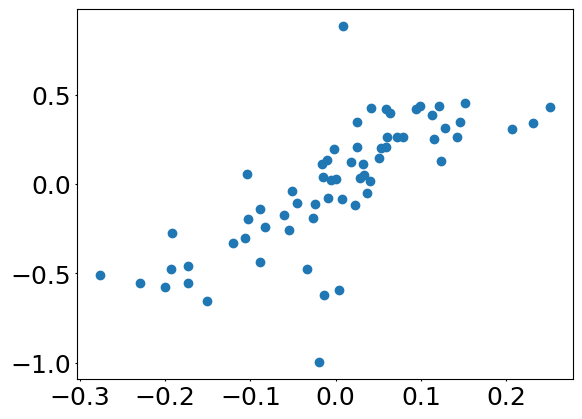

In [234]:
plt.scatter(sensorimotor_index, -modes_FC[0])

In [239]:
r_sensorimotor_functional = np.abs(spearmanr(sensorimotor_index, modes_FC[0])[0])

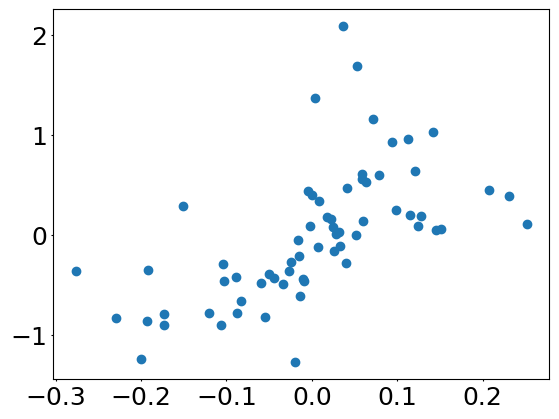

In [236]:
plt.scatter(sensorimotor_index, modes_SC[0])

In [240]:
r_sensorimotor_structural = np.abs(spearmanr(sensorimotor_index, modes_SC[0])[0])

#### Shuffling sensorimotor index

Functional

In [243]:
corrs_null = []

for _ in tqdm(range(1000), file=sys.stdout):
    base = Base(x=sensorimotor_index, D=distances, resample=True)
    surrogate = base(n=1)
    r = spearmanr(surrogate, modes_FC[0])[0]
    corrs_null.append(np.abs(r))

100%|███████████████████████████████████████| 1000/1000 [00:27<00:00, 36.27it/s]


In [245]:
percentileofscore(corrs_null, r_sensorimotor_functional)

100.0

Structural

In [246]:
corrs_null = []

for _ in tqdm(range(1000), file=sys.stdout):
    base = Base(x=sensorimotor_index, D=distances, resample=True)
    surrogate = base(n=1)
    r = spearmanr(surrogate, modes_SC[0])[0]
    corrs_null.append(np.abs(r))

100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.53it/s]


In [247]:
percentileofscore(corrs_null, r_sensorimotor_structural)

91.2

# High-resolution gradient

In [55]:
from sklearn.cluster import KMeans

In [56]:
volumes = np.copy(atlas.relativeVolumes)
volumes[10] = 0
volumes /= np.sum(volumes)

In [61]:
N_clusters_per_region = ((volumes * 1035) + 1).astype('int')
N_clusters_per_region[N_clusters_per_region > 1] -= 1

In [62]:
np.sum(N_clusters_per_region)

1001

In [46]:
region_centroids = []
region_labels = []

for r in tqdm(range(70), file=sys.stdout):
    N_clusters = N_clusters_per_region[r]
    mask = atlas.getRegionMask(r)[:, :, :284]
    mask = zoom(mask, (0.25, 0.25, 0.25), order=0)
    i, j, k = np.where(mask)
    centroids = np.stack([i, j, k], axis=1)
    kmeans = KMeans(n_clusters=N_clusters).fit(centroids)
    clusters = kmeans.labels_
    cluster_centroids = kmeans.cluster_centers_
    
    region_centroids.append(cluster_centroids)
    region_labels += [r] * N_clusters

# Reflecting on other hemisphere
region_centroids_left = np.concatenate(region_centroids, axis=0)
region_centroids_left = np.flip(region_centroids_left, axis=1) * 4
region_centroids_right = np.copy(region_centroids_left)
region_centroids_right[:, 0] = - (region_centroids_right[:, 0] - 284) + 284
region_centroids = np.concatenate([region_centroids_left, region_centroids_right], axis=0)
region_labels = np.array(region_labels + region_labels)

100%|███████████████████████████████████████████| 70/70 [01:59<00:00,  1.70s/it]


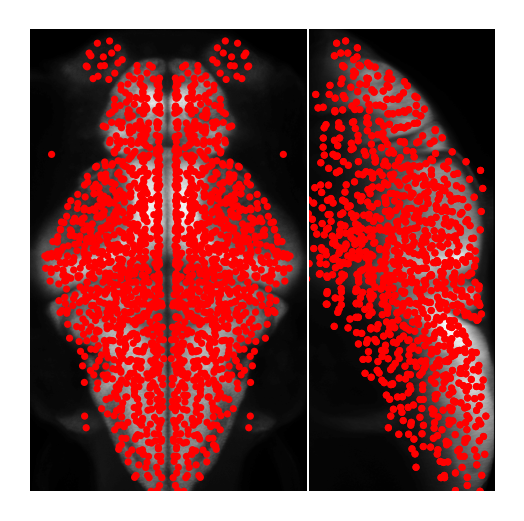

In [69]:
plot_centroids_on_atlas(region_centroids, atlas, alpha=1)
%matplotlib inline

In [48]:
np.save('Results/region_centroids_highres.npy', region_centroids)
np.save('Results/region_labels_highres.npy', region_labels)

# Hi-res sensorimotor gradient correlation - Spontaneous

In [20]:
import warnings

In [27]:
region_centroids_hires = np.load('Results/region_centroids_highres.npy')
region_labels_hires = np.load('Results/region_labels_highres.npy')

In [28]:
from sklearn.neighbors import NearestNeighbors

def find_nearest_neighbors(centroids1, centroids2):
    nn_model = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(centroids2)
    _, indices = nn_model.kneighbors(centroids1)
    return indices.flatten()

In [29]:
N_regions = int(len(region_labels_hires) / 2)

In [30]:
with warnings.catch_warnings():
    
    warnings.simplefilter("ignore")

    matrices = []
    N_neurons_all = []
    N_dark_all = []
    N_motor_all = []
    
    for folder in tqdm(datasets, file=sys.stdout):

        if any(identify_files(folder, ['motor.npy'])):
    
            region_series = np.zeros
                
            data = load_data(folder)
            region_labels = data['region_labels']
            region_labels[:, 10] = 0
            in_brain = np.sum(region_labels, axis=1) > 0
            centroids = data['centroids_atlas'][in_brain]
            cells_dark = np.load(folder + 'correlated_dark.npy')[in_brain]
            cells_motor = np.load(folder + 'correlated_motor.npy')[in_brain]
            dff = np.load(folder + 'dff.npy')[in_brain][:, :600] # Selecting first 10 minutes without stimulation
        
            NN = find_nearest_neighbors(centroids, region_centroids_hires)
    
            N_neurons, N_dark, N_motor = [], [], []
            region_series = np.zeros((N_regions * 2, dff.shape[1]))
            for i in range(N_regions * 2):
                c = centroids[NN == i]
                if np.any(c):
                    region_series[i] = gaussian_filter1d(np.mean(dff[NN == i], axis=0), 2)
                    N_neurons.append(c.shape[0])
                    N_dark.append(np.sum(cells_dark[NN == i]))
                    N_motor.append(np.sum(cells_motor[NN == i]))
                else:
                    N_neurons.append(0)
                    N_dark.append(0)
                    N_motor.append(0)
                    
            N_neurons_all.append(N_neurons)
            N_dark_all.append(N_dark)
            N_motor_all.append(N_motor)
                    
            region_series = 0.5 * (region_series[:N_regions] + region_series[N_regions:])
            matrix = np.corrcoef(region_series)
            matrices.append(matrix)

100%|███████████████████████████████████████████| 22/22 [03:09<00:00,  8.63s/it]


In [31]:
N_neurons = np.mean(np.stack(N_neurons_all), axis=0)
N_neurons = 0.5 * (N_neurons[:N_regions] + N_neurons[N_regions:])

N_dark = np.mean(np.stack(N_dark_all), axis=0)
N_dark = 0.5 * (N_dark[:N_regions] + N_dark[N_regions:])

N_motor = np.mean(np.stack(N_motor_all), axis=0)
N_motor = 0.5 * (N_motor[:N_regions] + N_motor[N_regions:])

In [32]:
fraction_dark = N_dark / (N_neurons + 1)
fraction_motor = N_motor / (N_neurons + 1)

In [33]:
sensorimotor_index = fraction_dark - fraction_motor

In [34]:
FC_hi = np.nanmean(np.stack(matrices), axis=0)
FC_hi[np.isnan(FC_hi)] = 0
#FC_hi = np.abs(FC_hi)

/tmp/ipykernel_8315/2337416533.py:1: RuntimeWarning: Mean of empty slice
  FC_hi = np.nanmean(np.stack(matrices), axis=0)


In [35]:
excluded_hi = np.where(np.sum(FC_hi, axis=0) == 0)[0]

In [36]:
FC_hi_ = np.delete(np.delete(FC_hi, excluded_hi, axis=0), excluded_hi, axis=1)
FC_hi_[np.diag_indices(FC_hi_.shape[0])] = 0
#FC_hi_[FC_hi_ < 0] = 0

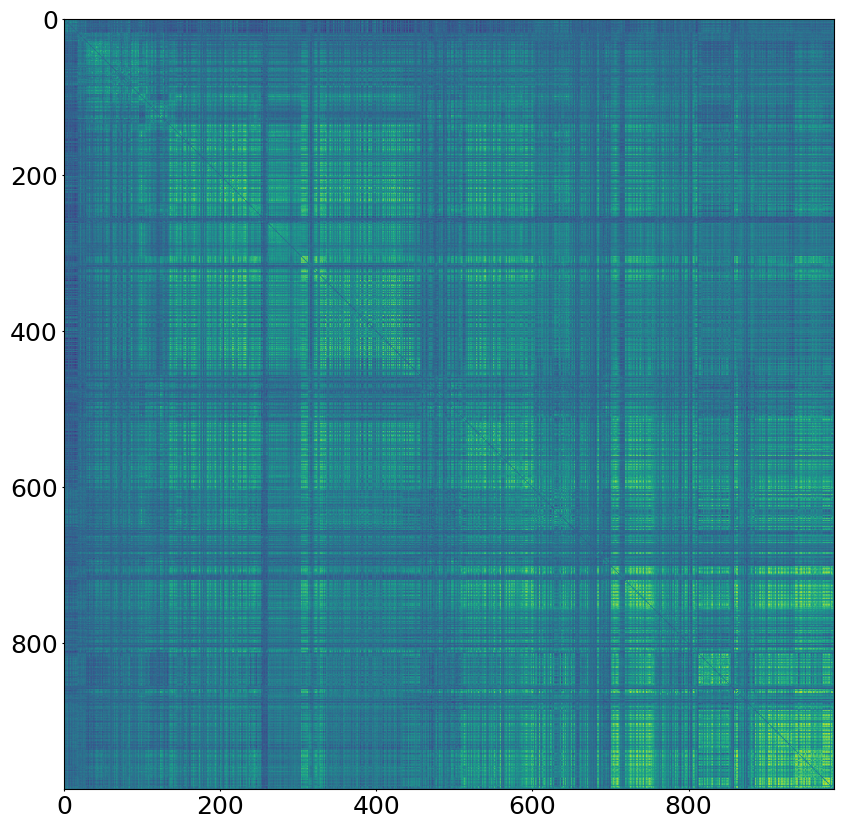

In [37]:
plt.figure(figsize=(10, 10))
plt.imshow(FC_hi_)

In [38]:
map = DiffusionMaps(n_components=10, alpha=0.5)
embedding = map.fit_transform(np.abs(FC_hi_))
gradient1f_hi = embedding[:, 0].flatten()
gradient2f_hi = embedding[:, 1].flatten()

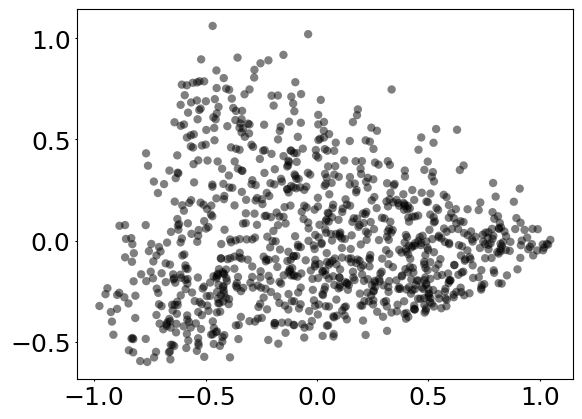

In [39]:
plt.scatter(gradient1f_hi, gradient2f_hi, color='black', alpha=0.5, edgecolor='None')

In [52]:
e

array([ 134,  253,  260,  263,  264,  265,  266,  268,  269,  525,  526,
        528,  529,  725, 1135, 1254, 1261, 1264, 1265, 1266, 1267, 1269,
       1270, 1526, 1527, 1529, 1530, 1726])

In [40]:
e = np.concatenate([excluded_hi, excluded_hi + N_regions])
c = np.delete(region_centroids_hires, e, axis=0)

(-0.5, 596.5, 973.5, -0.5)

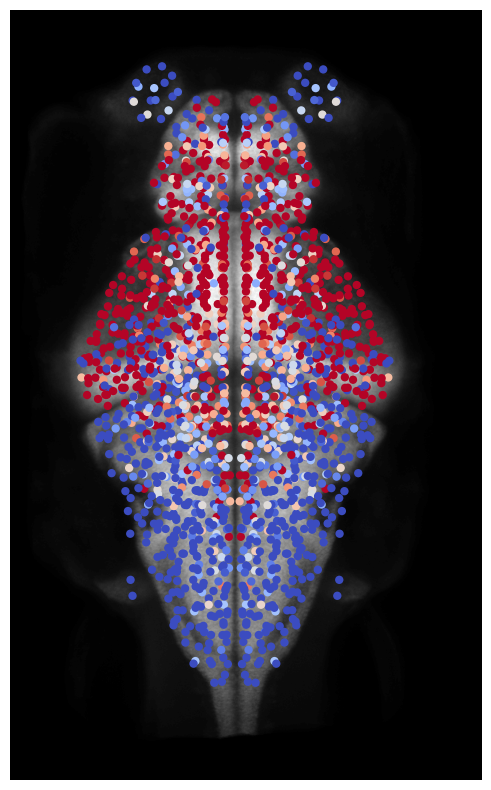

In [41]:
plt.figure(figsize=(10, 10))
plt.imshow(atlas.XYprojection, cmap='gray')
plt.scatter(c[:, 0], c[:, 1], edgecolor='None', c=double(embedding[:, 0].flatten()), cmap='coolwarm', vmin=-0.25, vmax=0.25)
plt.axis('off')

(-0.5, 973.5, 358.5, -0.5)

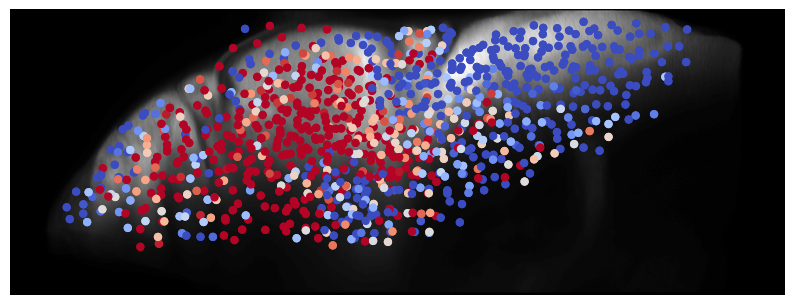

In [42]:
plt.figure(figsize=(10, 10))
plt.imshow(atlas.XZprojection, cmap='gray')
plt.scatter(c[:, 1], c[:, 2], edgecolor='None', c=double(embedding[:, 0].flatten()), cmap='coolwarm', vmin=-0.25, vmax=0.25)
plt.axis('off')

In [43]:
s = np.delete(sensorimotor_index, excluded_hi)

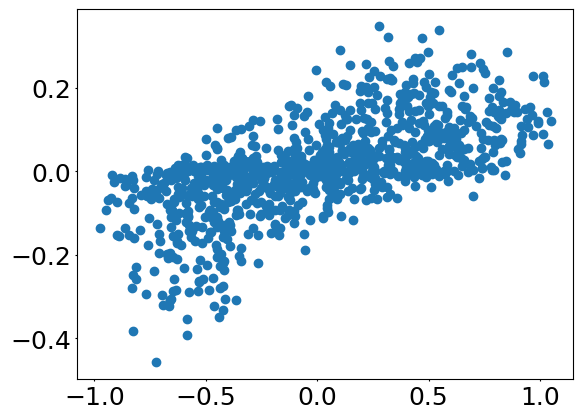

In [44]:
plt.scatter(gradient1f_hi, s)

In [45]:
from scipy.stats import spearmanr
spearmanr(gradient1f_hi, s)

SpearmanrResult(correlation=0.6862299164562182, pvalue=2.5459414051791472e-138)

In [53]:
np.save('Results/figure6_FC_hires_spontaneous.npy', FC_hi_)
np.save('Results/figure6_sensorimotor_index_hires.npy', np.delete(sensorimotor_index, excluded_hi))
np.save('Results/figure6_centroids_hires.npy', c)

np.save('centroids_hires.npy', c)
np.save('gradient1.npy', double(gradient1f_hi))
np.save('gradient2.npy', double(gradient2f_hi))

# Hi-res sensorimotor gradient correlation - Visual stimulation

In [104]:
import warnings

In [105]:
region_centroids_hires = np.load('Results/region_centroids_highres.npy')
region_labels_hires = np.load('Results/region_labels_highres.npy')

In [106]:
from sklearn.neighbors import NearestNeighbors

def find_nearest_neighbors(centroids1, centroids2):
    nn_model = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(centroids2)
    _, indices = nn_model.kneighbors(centroids1)
    return indices.flatten()

In [107]:
N_regions = int(len(region_labels_hires) / 2)

In [108]:
with warnings.catch_warnings():
    
    warnings.simplefilter("ignore")

    matrices = []
    N_neurons_all = []
    N_dark_all = []
    N_motor_all = []
    
    for folder in tqdm(datasets, file=sys.stdout):

        if any(identify_files(folder, ['motor.npy'])):
    
            region_series = np.zeros
                
            data = load_data(folder)
            region_labels = data['region_labels']
            region_labels[:, 10] = 0
            in_brain = np.sum(region_labels, axis=1) > 0
            centroids = data['centroids_atlas'][in_brain]
            cells_dark = np.load(folder + 'correlated_dark.npy')[in_brain]
            cells_motor = np.load(folder + 'correlated_motor.npy')[in_brain]
            dff = np.load(folder + 'dff.npy')[in_brain][:, :] # Selecting full sequence with visual stimulation
        
            NN = find_nearest_neighbors(centroids, region_centroids_hires)
    
            N_neurons, N_dark, N_motor = [], [], []
            region_series = np.zeros((N_regions * 2, dff.shape[1]))
            for i in range(N_regions * 2):
                c = centroids[NN == i]
                if np.any(c):
                    region_series[i] = gaussian_filter1d(np.mean(dff[NN == i], axis=0), 2)
                    N_neurons.append(c.shape[0])
                    N_dark.append(np.sum(cells_dark[NN == i]))
                    N_motor.append(np.sum(cells_motor[NN == i]))
                else:
                    N_neurons.append(0)
                    N_dark.append(0)
                    N_motor.append(0)
                    
            N_neurons_all.append(N_neurons)
            N_dark_all.append(N_dark)
            N_motor_all.append(N_motor)
                    
            region_series = 0.5 * (region_series[:N_regions] + region_series[N_regions:])
            matrix = np.corrcoef(region_series)
            matrices.append(matrix)

100%|███████████████████████████████████████████| 22/22 [00:54<00:00,  2.47s/it]


In [109]:
N_neurons = np.mean(np.stack(N_neurons_all), axis=0)
N_neurons = 0.5 * (N_neurons[:N_regions] + N_neurons[N_regions:])

N_dark = np.mean(np.stack(N_dark_all), axis=0)
N_dark = 0.5 * (N_dark[:N_regions] + N_dark[N_regions:])

N_motor = np.mean(np.stack(N_motor_all), axis=0)
N_motor = 0.5 * (N_motor[:N_regions] + N_motor[N_regions:])

In [110]:
fraction_dark = N_dark / (N_neurons + 1)
fraction_motor = N_motor / (N_neurons + 1)

In [111]:
sensorimotor_index = fraction_dark - fraction_motor

In [112]:
FC_hi = np.nanmean(np.stack(matrices), axis=0)
FC_hi[np.isnan(FC_hi)] = 0
#FC_hi = np.abs(FC_hi)

/tmp/ipykernel_13407/2337416533.py:1: RuntimeWarning: Mean of empty slice
  FC_hi = np.nanmean(np.stack(matrices), axis=0)


In [113]:
excluded_hi = np.where(np.sum(FC_hi, axis=0) == 0)[0]

In [114]:
FC_hi_ = np.delete(np.delete(FC_hi, excluded_hi, axis=0), excluded_hi, axis=1)
FC_hi_[np.diag_indices(FC_hi_.shape[0])] = 0
#FC_hi_[FC_hi_ < 0] = 0

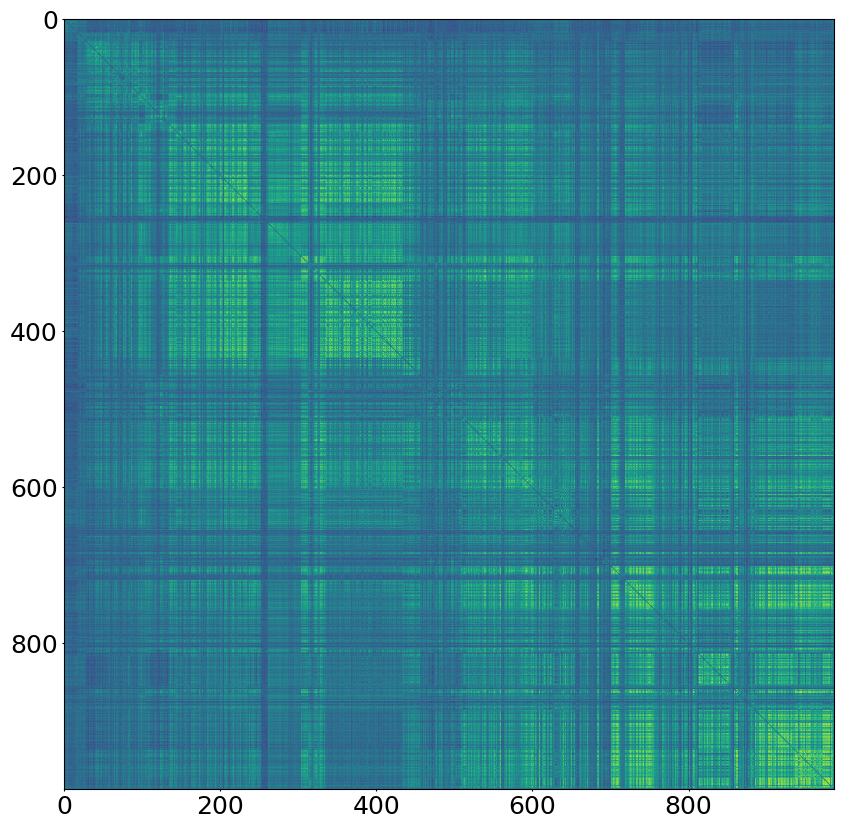

In [115]:
plt.figure(figsize=(10, 10))
plt.imshow(FC_hi_)

In [116]:
map = DiffusionMaps(n_components=10, alpha=0.5)
embedding = map.fit_transform(np.abs(FC_hi_))
gradient1f_hi = embedding[:, 0].flatten()
gradient2f_hi = embedding[:, 1].flatten()

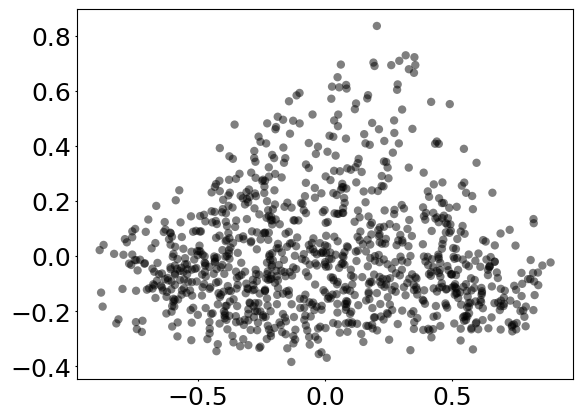

In [117]:
plt.scatter(gradient1f_hi, gradient2f_hi, color='black', alpha=0.5, edgecolor='None')

In [118]:
e = np.concatenate([excluded_hi, excluded_hi + N_regions])
c = np.delete(region_centroids_hires, e, axis=0)

(-0.5, 596.5, 973.5, -0.5)

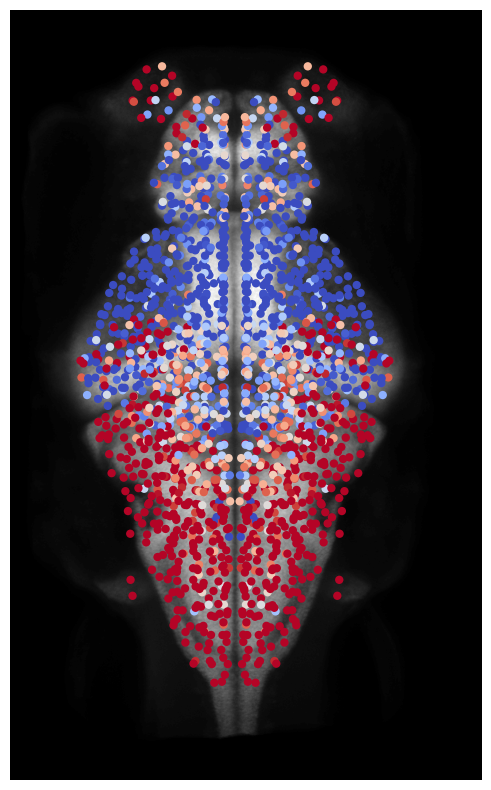

In [119]:
plt.figure(figsize=(10, 10))
plt.imshow(atlas.XYprojection, cmap='gray')
plt.scatter(c[:, 0], c[:, 1], edgecolor='None', c=double(embedding[:, 0].flatten()), cmap='coolwarm', vmin=-0.25, vmax=0.25)
plt.axis('off')

(-0.5, 973.5, 358.5, -0.5)

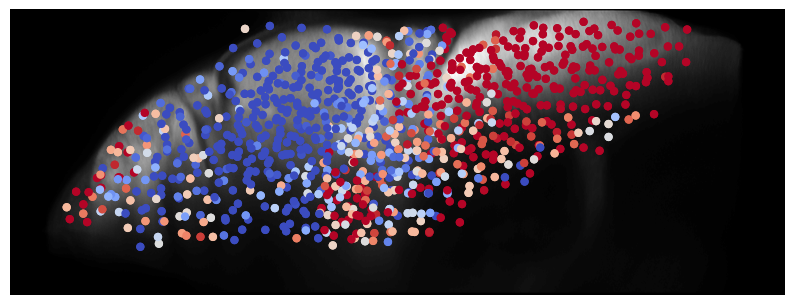

In [120]:
plt.figure(figsize=(10, 10))
plt.imshow(atlas.XZprojection, cmap='gray')
plt.scatter(c[:, 1], c[:, 2], edgecolor='None', c=double(embedding[:, 0].flatten()), cmap='coolwarm', vmin=-0.25, vmax=0.25)
plt.axis('off')

In [121]:
s = np.delete(sensorimotor_index, excluded_hi)

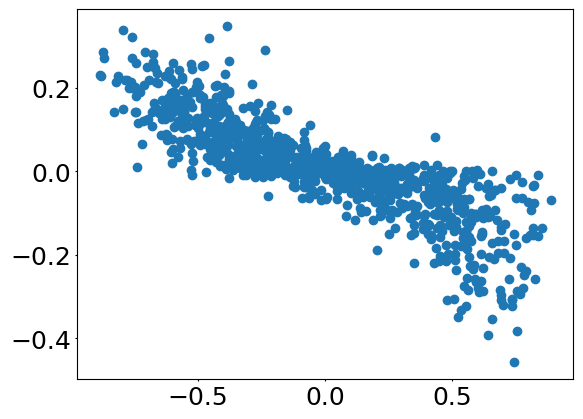

In [122]:
plt.scatter(gradient1f_hi, s)

In [123]:
from scipy.stats import spearmanr
spearmanr(gradient1f_hi, s)

SpearmanrResult(correlation=-0.8879400320706653, pvalue=0.0)

In [124]:
np.save('Results/figure6_FC_hires_stim.npy', FC_hi_)

np.save('centroids_hires.npy', c)
np.save('gradient1.npy', double(gradient1f_hi))
np.save('gradient2.npy', double(gradient2f_hi))

# Interpolated gradients

c = np.load('centroids_hires.npy')
gradient1f = np.load('gradient1.npy')
gradient2f = np.load('gradient2.npy')

In [121]:
from scipy.interpolate import Rbf

In [122]:
mask = np.load('Results/mask_atlas.npy')
mask = zoom(mask, (0.25, 0.25, 0.25), order=0)

In [123]:
def interpolate_3d(coordinates, values, mask, N_batches=5000, function='linear'):
    
    x, y, z = coordinates[:, 0], coordinates[:, 1], coordinates[:, 2]
    
    rbfi = Rbf(x, y, z, values, function=function)
    zi, yi, xi = np.where(mask)
    segments = np.linspace(0, len(xi), N_batches, endpoint=True).astype('int')
    interpolated_values = []
    for i in tqdm(range(len(segments) - 1), file=sys.stdout):
        i1, i2 = segments[i], segments[i+1]
        interpolated_values.append(rbfi(xi[i1:i2], yi[i1:i2], zi[i1:i2]))
        
    interpolated_volume = np.copy(mask).astype('float')
    interpolated_volume[interpolated_volume != 0] = np.concatenate(interpolated_values)
    
    return interpolated_volume

In [125]:
interpolated_gradient1 = interpolate_3d(c / 4, double(gradient1f_hi), mask)

100%|██████████████████████████████████████| 4999/4999 [00:20<00:00, 243.57it/s]


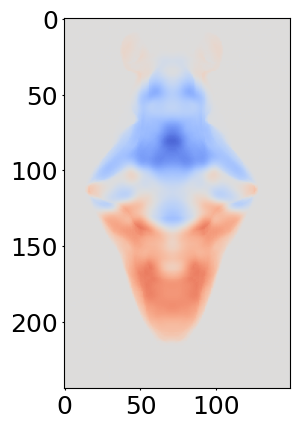

In [126]:
v = np.percentile(np.abs(interpolated_gradient1), 95)
plt.imshow(np.mean(interpolated_gradient1, axis=0), cmap='coolwarm', vmin=-v, vmax=v)

In [198]:
interpolated_gradient2 = interpolate_3d(c / 4, double(gradient2f_hi), mask)

100%|██████████████████████████████████████| 4999/4999 [00:18<00:00, 272.95it/s]


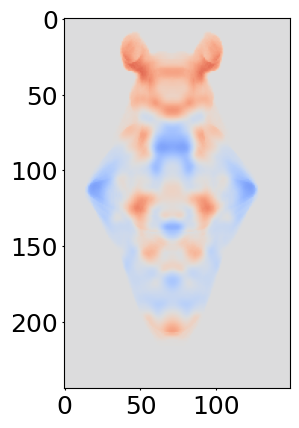

In [199]:
v = np.percentile(np.abs(interpolated_gradient2), 95)
plt.imshow(np.mean(interpolated_gradient2, axis=0), cmap='coolwarm', vmin=-v, vmax=v)

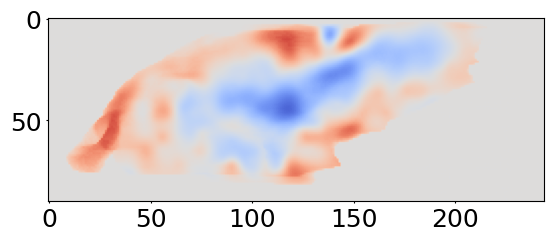

In [200]:
v = np.percentile(np.abs(interpolated_gradient2), 95)
plt.imshow(np.mean(interpolated_gradient2, axis=2), cmap='coolwarm', vmin=-v, vmax=v)

In [130]:
import tifffile

tifffile.imwrite('gradient1.tif', interpolated_gradient1.astype(np.float32), imagej=True)
tifffile.imwrite('gradient2.tif', interpolated_gradient2.astype(np.float32), imagej=True)

In [131]:
values1 = interpolated_gradient1[mask > 0]
values2 = interpolated_gradient2[mask > 0]

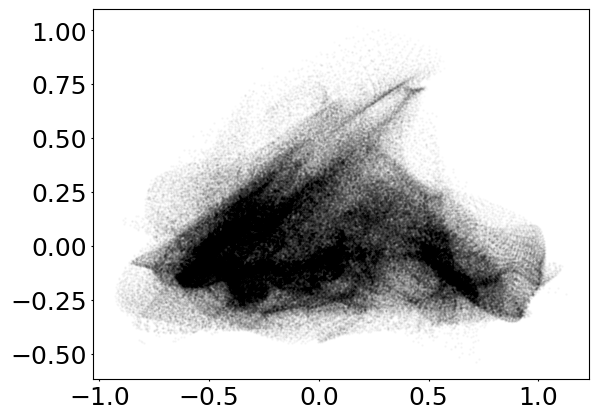

In [132]:
plt.scatter(values1, values2, alpha=0.01, color='black', s=1)

# Structural gradients in null SC

In [203]:
null_SC = np.load('Results/null_SC_expanded_deltaD_30.npy')

# Alternative implementation

In [ ]:
"""Generate a diffusion map embedding
"""

import numpy as np
from sklearn.base import BaseEstimator
import scipy.sparse as sps
from sklearn.neighbors import kneighbors_graph

def compute_diffusion_map(L, alpha=0.5, n_components=None, diffusion_time=0,
                          skip_checks=False, overwrite=False,
                          eigen_solver=None, return_result=False):
    """Compute the diffusion maps of a symmetric similarity matrix

        L : matrix N x N
           L is symmetric and L(x, y) >= 0

        alpha: float [0, 1]
            Setting alpha=1 and the diffusion operator approximates the
            Laplace-Beltrami operator. We then recover the Riemannian geometry
            of the data set regardless of the distribution of the points. To
            describe the long-term behavior of the point distribution of a
            system of stochastic differential equations, we can use alpha=0.5
            and the resulting Markov chain approximates the Fokker-Planck
            diffusion. With alpha=0, it reduces to the classical graph Laplacian
            normalization.

        n_components: int
            The number of diffusion map components to return. Due to the
            spectrum decay of the eigenvalues, only a few terms are necessary to
            achieve a given relative accuracy in the sum M^t.

        diffusion_time: float >= 0
            use the diffusion_time (t) step transition matrix M^t

            t not only serves as a time parameter, but also has the dual role of
            scale parameter. One of the main ideas of diffusion framework is
            that running the chain forward in time (taking larger and larger
            powers of M) reveals the geometric structure of X at larger and
            larger scales (the diffusion process).

            t = 0 empirically provides a reasonable balance from a clustering
            perspective. Specifically, the notion of a cluster in the data set
            is quantified as a region in which the probability of escaping this
            region is low (within a certain time t).

        skip_checks: bool
            Avoid expensive pre-checks on input data. The caller has to make
            sure that input data is valid or results will be undefined.

        overwrite: bool
            Optimize memory usage by re-using input matrix L as scratch space.

        References
        ----------

        [1] https://en.wikipedia.org/wiki/Diffusion_map
        [2] Coifman, R.R.; S. Lafon. (2006). "Diffusion maps". Applied and
        Computational Harmonic Analysis 21: 5-30. doi:10.1016/j.acha.2006.04.006
    """

    import numpy as np
    import scipy.sparse as sps

    use_sparse = False
    if sps.issparse(L):
        use_sparse = True

    if not skip_checks:
        from sklearn.manifold._spectral_embedding import _graph_is_connected
        if not _graph_is_connected(L):
            raise ValueError('Graph is disconnected')

    ndim = L.shape[0]
    if overwrite:
        L_alpha = L
    else:
        L_alpha = L.copy()

    if alpha > 0:
        # Step 2
        d = np.array(L_alpha.sum(axis=1)).flatten()
        d_alpha = np.power(d, -alpha)
        if use_sparse:
            L_alpha.data *= d_alpha[L_alpha.indices]
            L_alpha = sps.csr_matrix(L_alpha.transpose().toarray())
            L_alpha.data *= d_alpha[L_alpha.indices]
            L_alpha = sps.csr_matrix(L_alpha.transpose().toarray())
        else:
            L_alpha = d_alpha[:, np.newaxis] * L_alpha 
            L_alpha = L_alpha * d_alpha[np.newaxis, :]

    # Step 3
    d_alpha = np.power(np.array(L_alpha.sum(axis=1)).flatten(), -1)
    if use_sparse:
        L_alpha.data *= d_alpha[L_alpha.indices]
    else:
        L_alpha = d_alpha[:, np.newaxis] * L_alpha

    M = L_alpha

    from scipy.sparse.linalg import eigs, eigsh
    if eigen_solver is None:
        eigen_solver = eigs

    # Step 4
    func = eigen_solver
    if n_components is not None:
        lambdas, vectors = func(M, k=n_components + 1)
    else:
        lambdas, vectors = func(M, k=max(2, int(np.sqrt(ndim))))
    del M

    if func == eigsh:
        lambdas = lambdas[::-1]
        vectors = vectors[:, ::-1]
    else:
        lambdas = np.real(lambdas)
        vectors = np.real(vectors)
        lambda_idx = np.argsort(lambdas)[::-1]
        lambdas = lambdas[lambda_idx]
        vectors = vectors[:, lambda_idx]

    return _step_5(lambdas, vectors, ndim, n_components, diffusion_time,
                   return_result)


def _step_5(lambdas, vectors, ndim, n_components, diffusion_time, return_result):
    """
    This is a helper function for diffusion map computation.

    The lambdas have been sorted in decreasing order.
    The vectors are ordered according to lambdas.

    """
    psi = vectors/vectors[:, [0]]
    diffusion_times = diffusion_time
    if diffusion_time == 0:
        diffusion_times = np.exp(1. -  np.log(1 - lambdas[1:])/np.log(lambdas[1:]))
        lambdas = lambdas[1:] / (1 - lambdas[1:])
    else:
        lambdas = lambdas[1:] ** float(diffusion_time)
    lambda_ratio = lambdas/lambdas[0]
    threshold = max(0.05, lambda_ratio[-1])

    n_components_auto = np.amax(np.nonzero(lambda_ratio > threshold)[0])
    n_components_auto = min(n_components_auto, ndim)
    if n_components is None:
        n_components = n_components_auto
    embedding = psi[:, 1:(n_components + 1)] * lambdas[:n_components][None, :]

    if return_result:
        result = dict(lambdas=lambdas, vectors=vectors,
                      n_components=n_components, diffusion_time=diffusion_times,
                      n_components_auto=n_components_auto)
        return embedding, result
    else:
        return embedding


def compute_diffusion_map_psd(
        X, alpha=0.5, n_components=None, diffusion_time=0, return_result=False):
    """
    This variant requires L to be dense, positive semidefinite and entrywise
    positive with decomposition L = dot(X, X.T).

    """
    from scipy.sparse.linalg import svds

    # Redefine X such that L is normalized in a way that is analogous
    # to a generalization of the normalized Laplacian.
    d = X.dot(X.sum(axis=0)) ** (-alpha)
    X = X * d[:, np.newaxis]

    # Decompose M = D^-1 X X^T
    # This is like
    # M = D^-1/2 D^-1/2 X (D^-1/2 X).T D^1/2
    # Substituting U = D^-1/2 X we have
    # M = D^-1/2 U U.T D^1/2
    # which is a diagonal change of basis of U U.T
    # which itself can be decomposed using svd.
    d = np.sqrt(X.dot(X.sum(axis=0)))
    U = X / d[:, np.newaxis]

    if n_components is not None:
        u, s, vh = svds(U, k=n_components+1, return_singular_vectors=True)
    else:
        k = max(2, int(np.sqrt(ndim)))
        u, s, vh = svds(U, k=k, return_singular_vectors=True)

    # restore the basis and the arbitrary norm of 1
    u = u / d[:, np.newaxis]
    u = u / np.linalg.norm(u, axis=0, keepdims=True)
    lambdas = s*s
    vectors = u

    # sort the lambdas in decreasing order and reorder vectors accordingly
    lambda_idx = np.argsort(lambdas)[::-1]
    lambdas = lambdas[lambda_idx]
    vectors = vectors[:, lambda_idx]

    return _step_5(lambdas, vectors, X.shape[0], n_components, diffusion_time,
                   return_result)

class DiffusionMapEmbedding(BaseEstimator):
    """Diffusion map embedding for non-linear dimensionality reduction.

    Forms an affinity matrix given by the specified function and
    applies spectral decomposition to the corresponding graph laplacian.
    The resulting transformation is given by the value of the
    eigenvectors for each data point.

    Note : Laplacian Eigenmaps is the actual algorithm implemented here.

    Read more in the :ref:`User Guide <spectral_embedding>`.

    Parameters
    ----------

    diffusion_time : float
        Determines the scaling of the eigenvalues of the Laplacian

    alpha : float, optional, default: 0.5
        Setting alpha=1 and the diffusion operator approximates the
        Laplace-Beltrami operator. We then recover the Riemannian geometry
        of the data set regardless of the distribution of the points. To
        describe the long-term behavior of the point distribution of a
        system of stochastic differential equations, we can use alpha=0.5
        and the resulting Markov chain approximates the Fokker-Planck
        diffusion. With alpha=0, it reduces to the classical graph Laplacian
        normalization.

    n_components : integer, default: 2
        The dimension of the projected subspace.

    eigen_solver : {None, 'eigs' or 'eigsh'}
        The eigenvalue decomposition strategy to use.

    random_state : int, RandomState instance or None, optional, default: None
        A pseudo random number generator used for the initialization of the
        lobpcg eigenvectors.  If int, random_state is the seed used by the
        random number generator; If RandomState instance, random_state is the
        random number generator; If None, the random number generator is the
        RandomState instance used by `np.random`. Used when ``solver`` ==
        'amg'.

    affinity : string or callable, default : "nearest_neighbors"
        How to construct the affinity matrix.
         - 'nearest_neighbors' : construct affinity matrix by knn graph
         - 'rbf' : construct affinity matrix by rbf kernel
         - 'markov': construct affinity matrix by Markov kernel
         - 'cauchy': construct affinity matrix by Cauchy kernel
         - 'precomputed' : interpret X as precomputed affinity matrix
         - callable : use passed in function as affinity
           the function takes in data matrix (n_samples, n_features)
           and return affinity matrix (n_samples, n_samples).

    gamma : float, optional
        Kernel coefficient for pairwise distance (rbf, markov, cauchy)

    metric : string, optional
        Metric for scipy pdist function used to compute pairwise distances
        for markov and cauchy kernels

    n_neighbors : int, default : max(n_samples/10 , 1)
        Number of nearest neighbors for nearest_neighbors graph building.

    use_variant : boolean, default : False
        Use a variant requires L to be dense, positive semidefinite and
        entrywise positive with decomposition L = dot(X, X.T).

    n_jobs : int, optional (default = 1)
        The number of parallel jobs to run.
        If ``-1``, then the number of jobs is set to the number of CPU cores.

    Attributes
    ----------

    embedding_ : array, shape = (n_samples, n_components)
        Spectral embedding of the training matrix.

    affinity_matrix_ : array, shape = (n_samples, n_samples)
        Affinity_matrix constructed from samples or precomputed.

    References
    ----------

    - Lafon, Stephane, and Ann B. Lee. "Diffusion maps and coarse-graining: A
      unified framework for dimensionality reduction, graph partitioning, and
      data set parameterization." Pattern Analysis and Machine Intelligence,
      IEEE Transactions on 28.9 (2006): 1393-1403.
      https://doi.org/10.1109/TPAMI.2006.184

    - Coifman, Ronald R., and Stephane Lafon. Diffusion maps. Applied and
      Computational Harmonic Analysis 21.1 (2006): 5-30.
      https://doi.org/10.1016/j.acha.2006.04.006

    """

    def __init__(self, diffusion_time=0, alpha=0.5, n_components=2,
                 affinity="nearest_neighbors", gamma=None,
                 metric='euclidean', random_state=None, eigen_solver=None,
                 n_neighbors=None, use_variant=False, n_jobs=1):
        self.diffusion_time = diffusion_time
        self.alpha = alpha
        self.n_components = n_components
        self.affinity = affinity
        self.gamma = gamma
        self.metric = metric
        self.random_state = random_state
        self.eigen_solver = eigen_solver
        self.n_neighbors = n_neighbors
        self.use_variant = use_variant
        self.n_jobs = n_jobs

    @property
    def _pairwise(self):
        return self.affinity == "precomputed"

    def _get_affinity_matrix(self, X, Y=None):
        """Calculate the affinity matrix from data
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples
            and n_features is the number of features.

            If affinity is "precomputed"
            X : array-like, shape (n_samples, n_samples),
            Interpret X as precomputed adjacency graph computed from
            samples.

        Returns
        -------
        affinity_matrix, shape (n_samples, n_samples)
        """
        if self.affinity == 'precomputed':
            self.affinity_matrix_ = X
            return self.affinity_matrix_
        if self.affinity == 'nearest_neighbors':
            if sps.issparse(X):
                warnings.warn("Nearest neighbors affinity currently does "
                              "not support sparse input, falling back to "
                              "rbf affinity")
                self.affinity = "rbf"
            else:
                self.n_neighbors_ = (self.n_neighbors
                                     if self.n_neighbors is not None
                                     else max(int(X.shape[0] / 10), 1))
                self.affinity_matrix_ = kneighbors_graph(X, self.n_neighbors_,
                                                         include_self=True,
                                                         n_jobs=self.n_jobs)
                # currently only symmetric affinity_matrix supported
                self.affinity_matrix_ = 0.5 * (self.affinity_matrix_ +
                                               self.affinity_matrix_.T)
                return self.affinity_matrix_
        if self.affinity == 'rbf':
            self.gamma_ = (self.gamma
                           if self.gamma is not None else 1.0 / X.shape[1])
            self.affinity_matrix_ = rbf_kernel(X, gamma=self.gamma_)
            return self.affinity_matrix_
        if self.affinity in ['markov', 'cauchy']:
            from .dist import compute_affinity
            self.affinity_matrix_ = compute_affinity(X,
                                                     method=self.affinity,
                                                     eps=self.gamma,
                                                     metric=self.metric)
            return self.affinity_matrix_
        self.affinity_matrix_ = self.affinity(X)
        return self.affinity_matrix_

    def fit(self, X, y=None):
        """Fit the model from data in X.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples
            and n_features is the number of features.

            If affinity is "precomputed"
            X : array-like, shape (n_samples, n_samples),
            Interpret X as precomputed adjacency graph computed from
            samples.

        Returns
        -------
        self : object
            Returns the instance itself.
        """

        from sklearn.utils import check_array, check_random_state
        X = check_array(X, ensure_min_samples=2, estimator=self)

        random_state = check_random_state(self.random_state)
        if isinstance(self.affinity, (str,)):
            if self.affinity not in set(("nearest_neighbors", "rbf",
                                         "markov", "cauchy",
                                         "precomputed")):
                raise ValueError(("%s is not a valid affinity. Expected "
                                  "'precomputed', 'rbf', 'nearest_neighbors' "
                                  "or a callable.") % self.affinity)
        elif not callable(self.affinity):
            raise ValueError(("'affinity' is expected to be an affinity "
                              "name or a callable. Got: %s") % self.affinity)

        affinity_matrix = self._get_affinity_matrix(X)
        if self.use_variant:
            self.embedding_ = compute_diffusion_map_psd(affinity_matrix,
                                                        alpha=self.alpha,
                                                        n_components=self.n_components,
                                                        diffusion_time=self.diffusion_time)
        else:
            self.embedding_ = compute_diffusion_map(affinity_matrix,
                                                    alpha=self.alpha,
                                                    n_components=self.n_components,
                                                    diffusion_time=self.diffusion_time,
                                                    eigen_solver=self.eigen_solver)
        return self

    def fit_transform(self, X, y=None):
        """Fit the model from data in X and transform X.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples
            and n_features is the number of features.

            If affinity is "precomputed"
            X : array-like, shape (n_samples, n_samples),
            Interpret X as precomputed adjacency graph computed from
            samples.

        Returns
        -------
        X_new : array-like, shape (n_samples, n_components)
        """
        self.fit(X)
        return self.embedding_